# Image Denoising with Gibb Sampling Clearly Explained

## Let's start!
Let's start with some definition:
We have a binary image $x$ of size $(N, M)$ with some noise. That means that each pixel $x_{ij}$ can be only white or black (1, -1) and could be flipped with a certain unknown probability. We'd like to have our actual denoised image that we'll denote as $y$. Notice that we will define in uppercase the random variables $X$ or $Y$ and the instances/sample of this random variables in lower case, $x$, $y$ respectively.
We'll define the random variable $Y$ of the wanted denoised images to be composed by $N*M$ pixels, so $N*M$ random variables indexed as $Y_{ij}$ with $i$ and $j$, row and column respectively.

Now we want to create our probability distribution $P(Y| X = x)$ that means: "What is the probability distribution that defines Y given that the random variable X is exactly our image x?". **We're doing this because we assume (or better we'd like) that if we sample from this distribution that most probable resulting images would be a denoised version of $x$. But, is this the best way? In this case, it'll be better to define a deterministic link between the probability distribution and the wanted denoised image. For example, we can set that if $P(Y_{ij} = 1 | Y_{\backslash ij}, X = x) > 0.5 $ we'll set $ y_{ij} = 1$**.

Ok, now we need to cope with at least two problems:
1. **Distribution Definition Problem** 
    We need to define in some way this distribution, for example starting from some relations between the pixels. But once we have defined this distibution, are we able to compute it analitically? Or we need to estimate it?
2. **Estimation of the Probability Problem**  
    $Y$ is actually a multivariable distribution $Y_{ij}$ with $i \in [0, N-1]$ and $j \in [0, M-1]$, and it's possible that we would like to have the possibility to sample from it, but it's a multivariate distribution and this is a hard problem! $P(Y_{0,0}, ..., Y_{ij}, ... , Y_{N - 1,M - 1} | X = x)$.


## 1. Definition of a Probability Distribution that relates the pixels
What do we have to do with $P(Y | X = x)$? As already mentioned, we can say that the best way to use it in a binary images problem, is to consider that if $P(Y_{ij} = 1 | Y_{\backslash ij}, X = x) > 0.5 $ so $ y_{ij} = 1$. We can use this approach because considering a stable distribution we have in this way one and only one final denoised image. Because otherwise we can sample from the distribution undefinetely having multiple probably not good resulting image.
Perfect! But do we have analytically this distribution? Probably not, because, as we'll see later, we have $N*M$ unknown conditionally dependent variables. But are we able to sample from it? YES! And how to do it is the answer to the final problem to solve. 
So a good way is to sample multiple times from $P(Y_{ij} = 1 |Y_{\backslash ij}, X = x)$, estimate its value and use it to define $y_{ij} = 1$

### From an equation to a probability distribution

It's reasonable to think that each pixel can depend only on its neighbours let's say, following the image below:

![MRF](img.png)

So, we can impose that the random variable $Y_{ij}$ depends on $Y_{i-1,j}, Y_{i+1, j}, Y_{i, j-1}, Y_{i, j+1}$, that are the four neighbours, that we'll call $N(Y_{ij})$ and $X_{ij}$ that is the corresponding noisy pixel.

Ok, now we can say that it is of course easier using a "deterministic function" instead of a probabilistic ones.
In a binary image, where the pixels can be only black or white, we can set some kind of voting system where pixel should have a high probability to be equal to the neighbours pixels. For example, we can define some rules:
1. The function should give a high value when all the surrounding pixels are the same;
2. The function should give a low value when all the surrounding pixels are different, messy let's say. (high entropy?)

If for example we already have a proposal for the pixel $Y_{ij} = y_{ij}$ and all its neighbours $N(Y_{ij})$, and that the values of these pixels can be {1, -1}. How can we evaluate this proposal? Just a "Multiplication" is a good proposal!! 
$$
    E(Y_{ij} = y_{ij}, N(Y_{ij}) = N'(y_{ij}), X_{ij} = x_{ij}) = \alpha*y_{ij}x_{ij} + \beta*\sum_{ij \in N(y_{ij})} y_{ij}y_{i'j'}
$$
Using $\alpha$ and $\beta$ as hyperparameters. 
Why this equation could work?? Well, if all the values are 1, $E = \alpha + \beta*|N(y_{ij})|$, but also if all the values are -1 we have $E = \alpha + \beta*|N(y_{ij})|$. So, reflecting the first rule that we gave. Instead, if $\alpha = \beta$ to simplify, we have the lowest value of E when three over five values are different. Of course this depends also on the hyperparameters $\alpha$ and $\beta$.
Yes, Yes, but we need a probability distribution, here we have a deterministic equation instead and moreover we're assuming we already have all the values. So??

### Preliminaries: Boltzmann Distribution
A nice way to transform any function in a probability distribution is using the Boltzmann distribution that is in the form of:
$$
    P(X) = \frac{e^{-E(X)}}{\sum_{X} e^{-E(X)}} = \frac{e^{-E(X)}}{Z}
$$
Where $E(X)$ is called Energy and it's the function that we'd like to use to model our problem. In this case **The lower the energy the highest the probability, but we have defined our energy function in the opposite way!!! So we need to fix it! A minus sign is enough :)**
$$
    E(Y_{ij} = y_{ij}, N(Y_{ij}) = N'(y_{ij}), X_{ij} = x_{ij}) = - (\alpha*y_{ij}x_{ij} + \beta*\sum_{ij \in N(y_{ij})} y_{ij}y_{i'j'})
$$


Here we go! A problem is solved. But we need to think for a moment.
Remember that actually we only have $X = x$, but $Y$ and all its pixels are still random variables, so we'll have:
$$
    P(Y_{ij}, N(Y_{ij}) |X_{ij} = x) = \frac{e^{-E(Y_{ij}, N(Y_{ij}) | X_{ij} = x_{ij})}}{\sum_{values \in Y_{ij}, N(Y_{ij})} e^{-E(Y_{ij}, N(Y_{ij}) | X_{ij} = x_{ij})}} = \frac{e^{-E(y_{ij}, N(y_{ij}) | X_{ij} = x_{ij})}}{Z}
$$
But to make the things easier we want to focus on the single pixel so computing $P(Y_{ij} |N(Y_{ij}) = N'(Y_{ij}), X_{ij} = x)$ like if we had some samples of the neighbours $N'(Y_{ij})$ (we'll see later how we can assume this).
$$
    P(Y_{ij} |N(Y_{ij}) = N'(Y_{ij}), X_{ij} = x) = \frac{P(Y_{ij}, N(Y_{ij}) | X_{ij} = x)}{P(N(Y_{ij}) | X_{ij} = x)} = \frac{P(Y_{ij}, N(Y_{ij}) | X_{ij} = x)}{\sum_{ config \sim Y_{ij}}P(Y_{ij}, N(Y_{ij}) | X_{ij} = x)} = \frac{\frac{e^{-E(Y_{ij}, N(Y_{ij}) | X_{ij} = x_{ij})}}{Z}}{\sum_{ config \sim Y_{ij}}\frac{e^{-E(Y_{ij}, N(y_{ij}) | X_{ij} = x_{ij})}}{Z}} = \\
        \frac{e^{-E(Y_{ij}, N(Y_{ij}) | X_{ij} = x_{ij})}}{\sum_{ config \sim Y_{ij}} e^{-E(Y_{ij}, N(Y_{ij}) | X_{ij} = x_{ij})}} = \frac{e^{-E(Y_{ij}, N(Y_{ij}) | X_{ij} = x_{ij})}}{ e^{-E(Y_{ij} = 1, N(Y_{ij}) | X_{ij} = x_{ij})} + e^{-E(Y_{ij} = -1, N(y_{ij}) | X_{ij} = x_{ij})}}
$$

So,
$$
\begin{aligned}
    -E(Y_{ij} = 1, N(Y_{ij}) | X_{ij} = x_{ij}) &= \alpha*x_{ij} + \beta*\sum_{ij \in N(Y_{ij})} Y_{i'j'}  \\
    -E(Y_{ij} = -1, N(Y_{ij}) | X_{ij} = x_{ij}) &=  - (\alpha*x_{ij} + \beta*\sum_{ij \in N(Y_{ij})} Y_{i'j'})
\end{aligned}
$$
And,
$$
P(Y_{ij} |N(Y_{ij}) = N'(Y_{ij}), X_{ij} = x) = \frac{e^{\alpha*y_{ij}x_{ij} + \beta*\sum_{ij \in N(y_{ij})} y_{ij}y_{i'j'})}}{ e^{ \alpha*x_{ij} + \beta*\sum_{ij \in N(Y_{ij})} y_{i'j'}} + e^{-(\alpha*x_{ij} + \beta*\sum_{ij \in N(Y_{ij})} y_{i'j'})}}
$$

To still simplify the computation, let's say we would like to compute only when $Y_{ij} = 1$,
$$
P(Y_{ij} = 1 |N(Y_{ij}) = N'(Y_{ij}), X_{ij} = x) = \frac{e^{\alpha*x_{ij} + \beta*\sum_{ij \in N(y_{ij})} y_{i'j'})}}{ e^{\alpha*x_{ij} + \beta*\sum_{ij \in N(Y_{ij})} y_{i'j'}} + e^{-(\alpha*x_{ij} + \beta*\sum_{ij \in N(Y_{ij})} y_{i'j'})}}
$$
Reminding that:
$$
    \frac{e^{a}}{e^{a} + e^{-a}} = \frac{e^a}{ e^a + \frac{1}{e^a} } = \frac{e^{2a}}{1 + e^{2a}} = \frac{1}{1 + e^{-2a}}
$$
we finally have:
$$
P(Y_{ij} = 1 |N(Y_{ij}) = N'(Y_{ij}), X_{ij} = x) = \frac{1}{1 + e^{-2(\alpha*x_{ij} + \beta*\sum_{ij \in N(Y_{ij})} y_{i'j'})}
$$

## Okay... and now??

## Estimate the Probability values for each pixels
Gibbs sampling is a Markov Chain Monte Carlo algorithm for sampling for a specified multivariate probability distribution when direct sampling from a joint distribution is difficult, but sampling from a conditional distribution is more practical. 
Let's say we have $X = (X_1, ..., X_n)$ a multivariate random variable with $p(x_1, ..., x_n)$ joint distribution and we want to obtain $k$ samples from it. We proceed as follows:
1. We begin with some initial value $X^{(0)}$
2. We'd like the next sample $X^{(i+1)}$, but it's multivariate, and the components can be conditioned each other. Hence, we sample each component conditioned on all the other components sampled so far. But there is a catch: we sample our $j$th component conditioned till the $j-1$th. That is, sampling from $p(X_j^{i+1} | X_1^{i+1}, ..., X_{j-1}^{i+1}, X_{j+1}^{i}, ..., X_{N}^{i})$
3. Repeat the process $k$ times.

**After a certain burn-in period these samples are like being obtained from the joint distribution**

## Let's rewind for a moment!
We remember that we want $P(Y | X = x)$ and that $Y$ is multivariate distribution with interdependent variables ( since we defined that each variables is dependent from its four neighbours) and it would be good if it would be possible to estimate them, that's exactly the $X$ presented in the Gibbs Sampling algorithm. Morever, we already have a conditional distribution formula to use (of course because I explained everything backward :P). Hence:
1. Run a Gibbs Sampler for our $Y$ for a burn-in period
2. Take $k$ samples from each $P(Y_{ij}| ...) \forall ij$
3. Estimate $P(Y_{ij} = 1 \ ...)$ from the $k$ samples: $P(Y_{ij} = 1 \ ...) \approx \frac{1}{K} \sum_{k=1}^{K} y_{ij}$ with $y_{ij} = 1$
4. Set the denoised pixel as 1 if $P(Y_{ij} = 1 \ ...) > 0.5$

## Let's start to code!
At first we need to import our noisy image $x$.
Note that since we are considering the four neighbours, we have a problem on the borders in which case the neighbours will be only 2! 
We can solve this issue just adding a bit of padding :)

In [6]:
import numpy as np
import torch
from matplotlib import pyplot as plt
def load_image(filename):
    my_img = plt.imread(filename)
    img_gray = np.dot(my_img[..., :3], [0.2989, 0.5870, 0.1140])
    img_gray = np.where(img_gray > 0.5, 1, -1)
    img_padded = np.zeros([img_gray.shape[0] + 2, img_gray.shape[1] + 2]) ## Add padding
    img_padded[1:-1, 1:-1] = img_gray
    return img_padded

As described in the Gibb Sampling Algorithm a random initialization for our $Y$ it's enough.

In [7]:
X = load_image("image.png")
Y = np.random.choice([1, -1], size=X.shape) ## random init

Now we need to define the posterior for the single component of $Y$. We report the function for simplicity:
$$
P(Y_{ij} = 1 |N(Y_{ij}) = N'(Y_{ij}), X_{ij} = x) = \frac{1}{1 + e^{-2(\alpha*x_{ij} + \beta*\sum_{ij \in N(Y_{ij})} y_{i'j'})}
$$

In [8]:
import math
def sample_y(i, j, Y, X, alpha=1, beta=1):
    markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
    w = alpha*markov_blanket[-1] + beta*sum(markov_blanket[:4])
    prob = 1 / (1 + math.exp(-2*w))
    return (np.random.rand() < prob) * 2 - 1


Ok, now we need to develop the Gibb sampler. First we need to define the **Burn-in period** and the **Sample size** that we will use to estimate each $P(Y_{ij} = 1 | N(Y_{ij}, X_{ij} = x_{ij})$. So, for this reason a for loop is enough.

Then remember from the Gibbs sampling algorithm the we need to sample from $p(X_j^{i+1} | X_1^{i+1}, ..., X_{j-1}^{i+1}, X_{j+1}^{i}, ..., X_{N}^{i})$, and updating a pixel at time the whole image. So, we use a double loop (one for the rows, one for the column) and save each pixel sample in a temporary storage.

We expect, that after a certain **burn-in** period, the whole image sampled is like has been sampled from $P(Y | X=x)$, that is exactly what we are looking for.
In fact, after the burn-in period we save the whole images sampled.
Actually in our example, since the image is binary, it's easier to just save how many times we find that the pixel is one, then diving by the sample size ( remember $P(Y_{ij} = 1 \ ...) \approx \frac{1}{K} \sum_{k=1}^{K} y_{ij}$ with $y_{ij} = 1$)

In [9]:
from tqdm import tqdm 
def gibbs_sampler(X, Y, K = 10, n_burn_in_steps=10):
    posterior = np.zeros(X.shape)
    for step in tqdm(range(n_burn_in_steps + K)):
        for i in range(1, X.shape[0] - 1):
            for j in range(1, X.shape[1] - 1):
                y = sample_y(i, j, Y, X)
                Y[i,j] = y
                if step > n_burn_in_steps and y == 1:
                    posterior[i, j] += 1
    posterior /= K
    return posterior

## Now we can start our computation!

In [10]:
posterior = gibbs_sampler(X, Y, K= 20, n_burn_in_steps=50)

100%|██████████| 70/70 [00:26<00:00,  2.69it/s]


Now that we have estimated our $P(Y_{ij} | ...) \forall ij$ we can extract our image following $P(Y_{ij} | ...) > 0.5$ then $y_{ij} = 1$

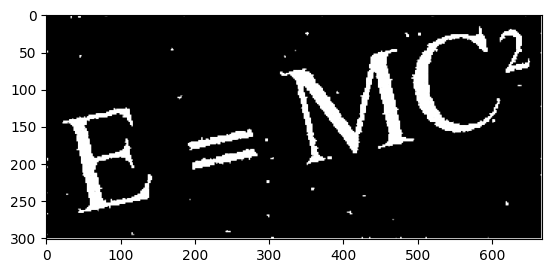

In [11]:
posterior[posterior > 0.5] = 1
plt.imshow(posterior, cmap="binary")

# And....We're DONE!

## Some additional notes: Maximum A Posteriori
Let's suppose that we have a sample of values $x_1, ..., x_n$ of a random variable $X$ that follow a certain probability distribution $P(X)$ that actually depends on some parameters, let's say $\theta$. Our problem now is to find the parameter that better explains the sample, so maximizing $P(X=x_1, X=x_2, ..., X=x_n | \theta)$. To deal with this problem we have different possibilities (MLE is an example). MAP, instead sees this problem in the different way. Using the Bayes theorem:
$$
    P(\theta | X) = \frac{P(X|\theta)P(\theta)}{P(X)}
$$
Of course here we are considering that $\theta$ is a random variable, with a certain prior distribution $P(\theta)$ (that in general is unknown and fixed in some way, there are a lot of debates on its choice of course). So, here we are saying that considering that we have a certain sample $x_1, ..., x_n$, we should have a probability distribution of \theta with a mode that better explains "why we have that sample" and we want to find the value of that mode:
$$
    \hat{\theta}_{MAP} = \underset{\theta}{\operatorname{argmax}} \frac{P(X|\theta)P(\theta)}{P(X)}
$$
Considering that we are not looking for a probability distribution, but a single value we can get rid of the denominator
$$
    \hat{\theta}_{MAP} = \underset{\theta}{\operatorname{argmax}} P(X|\theta)P(\theta)
$$
Considering i.i.d samples and applying the log
$$
    \hat{\theta}_{MAP} = \underset{\theta}{\operatorname{argmax}} \prod_i^nP(X_i|\theta)P(\theta) 
        = \underset{\theta}{\operatorname{argmax}} log \prod_i^nP(X = x_i|\theta)P(\theta) 
        = \underset{\theta}{\operatorname{argmax}} \sum_i^n log P(X = x_i|\theta)P(\theta) 
        = \underset{\theta}{\operatorname{argmax}} \sum_i^n log P(X = x_i|\theta) + log P(\theta) 
$$

Let's go back to our problem of the denoising of the image. We can consider our parameter $\theta$ to be our random variable $Y$ of the denoised image. So asking what is the value of $Y$ that better explain our image $X$. But we can get a step back and remind that $ P(X|Y) = \frac{P(X, Y)}{P(Y)}$, so $P(X,Y) = P(X|Y)P(Y)$. But wait we have $P(X,Y)$!!
$$
    P(X,Y) = \frac{e^{\sum_i^N \sum_j^M (\alpha*x_{ij}y_{ij} + \beta* \sum_{N(y_{ij})} y_{ij}y_{ij}')}}{Z}
$$
Where $E(X,Y) = \sum_i^N \sum_j^M (\alpha*x_{ij}y_{ij} + \beta* \sum_{N(y_{ij})} y_{ij}y_{ij}')$ is the energy of the whole system. So,
$$
    \hat{Y} = \underset{y}{\operatorname{argmax}} P(X|Y) P(Y) = \underset{y}{\operatorname{argmax}} P(X,Y) =  \underset{y}{\operatorname{argmax}} \frac{e^{\sum_i^N \sum_j^M (\alpha*x_{ij}y_{ij} + \beta* \sum_{N(y_{ij})} y_{ij}y_{ij}')}}{Z}
$$


Using the log trick (the points that maximize a certain function don't get affected if we apply the logarithm on it since it is a monotonic increasing function) and modifing the problem in a minimization problem, we get:

$$
    \hat{Y} = \underset{y}{\operatorname{argmax}} \frac{e^{\sum_i^N \sum_j^M (\alpha*x_{ij}y_{ij} + \beta* \sum_{N(y_{ij})} y_{ij}y_{ij}')}}{Z} = \underset{y}{\operatorname{argmin}} - log \frac{e^{\sum_i^N \sum_j^M (\alpha*x_{ij}y_{ij} + \beta* \sum_{N(y_{ij})} y_{ij}y_{ij}')}}{Z} = - E(X,Y) + log(Z)
$$

Now besides the constant $Z$, we can see that the Gibbs sampling process tries to minimize the energy function. 

In [ ]:
def energy(X, Y, alpha=1, beta=1):
    def get_energy(i, j, X, Y, alpha=1, beta=1):
        return alpha*X[i, j]*Y[i,j] + beta*Y[i,j]*np.sum([Y[i - 1,j],  Y[i + 1,j],  Y[i,j - 1], Y[i,j + 1]])
    energy = 0
    for i in range(1, X.shape[0] - 1):
        for j in range(1, X.shape[1]- 1):
            energy += get_energy(i, j, X, Y)
    return -energy

Let's modify the gibbs sampler to extract the energy:

In [ ]:
from tqdm import tqdm 
def gibbs_sampler_modified(X, Y, K = 10, n_burn_in_steps=10):
    energy_history = []
    posterior = np.zeros(X.shape)
    for step in tqdm(range(n_burn_in_steps + K)):
        for i in range(1, X.shape[0] - 1):
            for j in range(1, X.shape[1] - 1):
                y = sample_y(i, j, Y, X)
                Y[i,j] = y
                if step > n_burn_in_steps and y == 1:
                    posterior[i, j] += 1
        energy_history.append(energy(X,Y))
    posterior /= K
    return posterior, energy_history

In [ ]:
Y = np.random.choice([1, -1], size=X.shape) ## random init
posterior, energy_history = gibbs_sampler_modified(X, Y, K= 30, n_burn_in_steps=20)
posterior[posterior > 0.5] = 1
fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.tight_layout(pad=2)
ax[0].imshow(posterior, cmap="binary")
ax[0].axis("off")
ax[1].plot(energy_history)
ax[1].set_xlabel('Steps')
ax[1].set_ylabel('Energy')

## The End

# Bibliography

1. Main reference: Image Denoising with Gibbs Sampling (MCMC) https://towardsdatascience.com/image-denoising-with-gibbs-sampling-mcmc-concepts-and-code-implementation-11d42a90e153 
2. https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation
3. https://medium.com/@philipyunsoocho/image-denoising-by-gibbs-sampling-67d1ad3d7344